In [1]:
STOCK_SIZE = 100

In [2]:
def read_instance(path):
    with open(path, 'r') as f:
        orders = [int(x) for x in f.readline().split()]
        return orders

# CPLEX

In [10]:
from docplex.mp.model import Model
from time import perf_counter
import pandas as pd

In [22]:
def cplex_solver(cplex_df, num_instance, orders):
    start = perf_counter()
    
    model = Model(name=f'CSP{num_instance}')
    num_stocks = len(orders)
    num_orders = len(orders)

    order_list = model.integer_var_list(num_orders, lb=orders, ub=orders, name='orders')

    order_placement = model.binary_var_matrix(num_stocks, num_orders, name='order_placement')
    stock_used = model.binary_var_list(num_stocks, name='stock_used')

    for i in range(num_stocks):
        model.add_constraint(sum(order_placement[i,j] * order_list[j] for j in range(num_orders)) <= STOCK_SIZE * stock_used[i])

    for j in range(num_orders):
        model.add_constraint(sum(order_placement[i,j] for i in range(num_stocks)) == 1)

    model.minimize(sum(stock_used))
    
    solution = model.solve()
    
    end = perf_counter() 
    
    print(f'Stocks used for instance {num_instance}: {solution.get_objective_value()}')
    
    cplex_df.loc[0, f'instance {num_instance} num stocks'] = solution.get_objective_value()
    cplex_df.loc[0, f'instance {num_instance} time'] = end-start

In [48]:
orders = read_instance('test_instances/test_instance_11.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)
cplex_solver(orders)

775902 317
299.0


In [32]:
cplex_df = pd.DataFrame()

for i in range(15):
    orders = read_instance(f'test_instances/test_instance_{i}.csp')
    cplex_solver(cplex_df, i, orders)

In [70]:
cplex_df

,instance 0 num stocks,instance 0 time,instance 1 num stocks,instance 1 time,instance 2 num stocks,instance 2 time,instance 3 num stocks,instance 3 time,instance 4 num stocks,instance 4 time,...,instance 10 num stocks,instance 10 time,instance 11 num stocks,instance 11 time,instance 12 num stocks,instance 12 time,instance 13 num stocks,instance 13 time,instance 14 num stocks,instance 14 time
0,17,0.425326,20,0.277497,49,16.013496,47,6.825647,33,1.363269,...,76,272.816822,299,54.968373,NaN,NaN,172,904.146431,308,1625.924981


In [35]:
cplex_df.to_csv('cplex.csv')

# Simulated annealing

In [3]:
import math
from matplotlib import pyplot as plt
import random
from copy import deepcopy

In [4]:
def initialize(orders: list[int], shuffle: bool = False) -> list[int]:
    solution = deepcopy(orders)
    if shuffle:
        random.shuffle(solution)
    return solution

In [5]:
def calc_solution_value(orders: list[int]) -> tuple[int, int]:
    
    leftovers = []
    num_stocks = 0
    current_stock_size = STOCK_SIZE
    
    for order in orders:
        if order <= current_stock_size:
            current_stock_size -= order
        else:
            leftover = current_stock_size
            leftovers.append(leftover)
            num_stocks += 1
            current_stock_size = STOCK_SIZE - order
    
    if current_stock_size != STOCK_SIZE:
        leftovers.append(current_stock_size)
        
    leftovers.sort(reverse = True)
        
    result = 0    
    for i, leftover in enumerate(leftovers):
        if leftover == 0:
            break
        result += (i+1) * leftover
        
    return result, num_stocks

In [6]:
def swap(orders: list[int]): 
    idx1 = random.randrange(len(orders))
    idx2 = random.randrange(len(orders))
    while orders[idx1] == orders[idx2]:
        idx2 = random.randrange(len(orders))
        
    tmp = orders[idx1]
    orders[idx1] = orders[idx2]
    orders[idx2] = tmp
    
def insert(orders: list[int]):
    pos1 = random.randrange(len(orders))
    pos2 = random.randrange(len(orders))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(orders))
        
    element = orders.pop(pos1)
    orders.insert(pos2, element)
    
def inverse(orders: list[int]):
    pos1 = random.randrange(len(orders))
    pos2 = random.randrange(len(orders))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(orders))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
        
    orders[pos1:pos2 + 1] = orders[pos1:pos2 + 1][::-1]
    
def shuffle(orders):
    pos1 = random.randrange(len(orders))
    pos2 = random.randrange(len(orders))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(orders))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
                
    segment = orders[pos1:pos2+1]
    random.shuffle(segment)
    
    orders[pos1:pos2+1] = segment

In [7]:
def calc_temperature_1(current_temp: float, alpha: float) -> float:
    return current_temp / (1 + alpha * current_temp)

def calc_temperature_2(current_temp: float, alpha: float) -> float:
    return current_temp * alpha

def calc_alpha(initial_temp: float, min_temp: float, num_iters: int) -> float:
    return (initial_temp - min_temp) / (num_iters * initial_temp * min_temp)

In [11]:
from typing import Callable

In [12]:
def simulated_annealing(orders: list[int],
                        initial_temp: float = 100,
                        min_temp: float = 1,
                        alpha: float = None,
                        max_iters: int = 5000,
                        make_small_change: Callable[[list[int]], None] = swap,
                        calc_temperature: Callable[[float, float], float] = calc_temperature_1,
                        plot: bool = False,
                        max_accepted_solutions: int = 2,
                        sum_best_values: list[int] = None,
                        sum_num_stocks: list[int] = None,
                        sum_value_perc_improvement: list[float] = None,
                        sum_num_stocks_perc_improvement: list[float] = None
                        ) -> tuple[list[int], int, int]:
    if alpha is None:
        alpha = calc_alpha(initial_temp, min_temp, max_iters)
    
    num_orders = len(orders)
    solution = initialize(orders)
    temperature = initial_temp
    
    value, stocks_used = calc_solution_value(solution)
    best_solution = deepcopy(solution)
    best_value = value
    best_stocks_used = stocks_used

    PLT_VALUES = []
    PLT_STOCKS_USED = []
    ITERS = 0
        
    while temperature > min_temp and ITERS < max_iters:
        accepted_solutions = 0
        new_solution = deepcopy(solution)
        make_small_change(new_solution)
        new_value, new_stocks_used = calc_solution_value(new_solution)
        
        diff = new_value - value
        if diff <= 0:
            solution = deepcopy(new_solution)
            value = new_value
            stocks_used = new_stocks_used
            
            if new_value < best_value:
                best_value = new_value
                best_solution = deepcopy(new_solution)
                best_stocks_used = new_stocks_used
                
            accepted_solutions += 1    
            
        elif random.random() < (math.e)**((-diff) / temperature):
                value = new_value
                solution = deepcopy(new_solution)
                stocks_used = new_stocks_used
                accepted_solutions += 1
        
        if diff > 0 or accepted_solutions >= max_accepted_solutions:
            temperature = calc_temperature(temperature, alpha)
                    
        PLT_VALUES.append(value)
        PLT_STOCKS_USED.append(stocks_used)
        ITERS += 1
          
# -------------------------------------------------------------------------------------

    if plot:      
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
        
    if sum_best_values is not None:
        if len(PLT_VALUES) < len(sum_best_values):
            PLT_VALUES.extend([PLT_VALUES[-1]] * (len(sum_best_values) - len(PLT_VALUES)))
        
        for i in range(len(sum_best_values)):
            sum_best_values[i] = sum_best_values[i] + PLT_VALUES[i]
        
    if sum_num_stocks is not None:
        if len(PLT_STOCKS_USED) < len(sum_num_stocks):
            PLT_STOCKS_USED.extend([PLT_STOCKS_USED[-1]] * (len(sum_num_stocks) - len(PLT_STOCKS_USED)))
        for i in range(len(sum_num_stocks)):
            sum_num_stocks[i] = sum_num_stocks[i] + PLT_STOCKS_USED[i]
            
    if sum_value_perc_improvement is not None:
        if len(PLT_VALUES) < len(sum_value_perc_improvement):
            PLT_VALUES.extend([PLT_VALUES[-1]] * (len(sum_value_perc_improvement) - len(PLT_VALUES)))
        
        initial_val = PLT_VALUES[0]
        perc_improvement = [((initial_val - val) / initial_val * 100) for val in PLT_VALUES]
        
        for i in range(len(sum_value_perc_improvement)):
            sum_value_perc_improvement[i] = sum_value_perc_improvement[i] + perc_improvement[i]
            
    if sum_num_stocks_perc_improvement is not None:
        if len(PLT_STOCKS_USED) < len(sum_num_stocks_perc_improvement):
            PLT_STOCKS_USED.extend([PLT_STOCKS_USED[-1]] * (len(sum_num_stocks_perc_improvement) - len(PLT_STOCKS_USED)))
    
        initial_num_stocks = PLT_STOCKS_USED[0]
        perc_improvement = [((initial_num_stocks - num_stocks) / initial_num_stocks * 100) for num_stocks in PLT_STOCKS_USED]
        
        for i in range(len(sum_num_stocks_perc_improvement)):
            sum_num_stocks_perc_improvement[i] = sum_num_stocks_perc_improvement[i] + perc_improvement[i]
        
    return best_solution, best_value, best_stocks_used

In [65]:
orders = read_instance('test_instances/test_instance_20.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

4478851 751


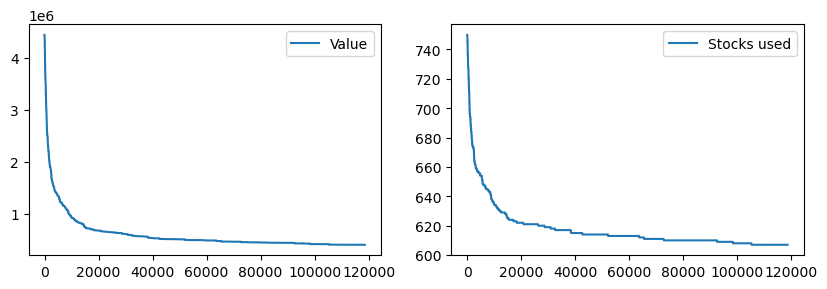

407144 607


In [68]:
solution, value, stocks_used = simulated_annealing(orders, plot=True, max_iters=1000000, min_temp=1)
print(value, stocks_used)

### Parameter tuning

In [10]:
def sa_test_all_instances(results_df,
                          combination_num,
                          initial_temp,
                          min_temp,
                          max_accepted_solutions,
                          calc_temperature,
                          make_small_change
                         ):

    for i in range(21):
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        _, value, stocks_used = simulated_annealing(orders,
                                                    initial_temp=initial_temp,
                                                    min_temp=min_temp,
                                                    max_accepted_solutions=max_accepted_solutions,
                                                    calc_temperature=calc_temperature,
                                                    make_small_change=make_small_change
                                                   )
        
        results_df.loc[combination_num, 'make_small_change function'] = make_small_change.__name__
        results_df.loc[combination_num, [f'instance {i} value', f'instance {i} num stocks']] = [value, stocks_used]

#### Grid search

In [36]:
import pandas as pd

In [33]:
initial_temps = [50, 100, 300, 500, 750, 1000]
min_temps = [1, 5, 10, 15]
max_accepted = [1, 2, 3, 4, 5, float('inf')]

grid_search_df = pd.DataFrame(columns=['initial_temp', 'min_temp', 'max_acc_solutions'])
combination_num = 0

for initial_temp in initial_temps:
    for min_temp in min_temps:
        for max_acc in max_accepted:
            print(f'Combination {combination_num+1}/144   ', end='\r')
            sa_test_all_instances(results_df=grid_search_df,
                                  combination_num=combination_num,
                                  initial_temp=initial_temp,
                                  min_temp=min_temp,
                                  max_accepted_solutions=max_acc
                                 )
            combination_num += 1

In [121]:
grid_search_df

,initial_temp,min_temp,max_acc_solutions,instance 0 value,instance 0 num stocks,instance 1 value,instance 1 num stocks,instance 2 value,instance 2 num stocks,instance 3 value,...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,50,1,1,615.0,16.0,194.0,19.0,5300.0,48.0,1578.0,...,13326.0,164.0,2079439.0,594.0,354453.0,444.0,172021.0,371.0,1299335.0,650.0
1,50,1,2,615.0,16.0,173.0,19.0,4929.0,48.0,1645.0,...,15772.0,165.0,2130887.0,596.0,352454.0,444.0,173492.0,370.0,1226747.0,647.0
2,50,1,3,615.0,16.0,191.0,19.0,4904.0,48.0,1100.0,...,13588.0,164.0,2085605.0,595.0,367641.0,446.0,167431.0,371.0,1252708.0,649.0
3,50,1,4,615.0,16.0,151.0,19.0,4922.0,48.0,1318.0,...,12743.0,163.0,2062251.0,593.0,406605.0,449.0,140152.0,365.0,1256373.0,648.0
4,50,1,5,615.0,16.0,163.0,19.0,4874.0,48.0,717.0,...,11776.0,164.0,2134009.0,597.0,333198.0,444.0,153763.0,370.0,1228428.0,646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1000,15,2,624.0,16.0,308.0,19.0,5028.0,48.0,1648.0,...,14969.0,165.0,2041432.0,593.0,327292.0,442.0,153310.0,368.0,1194112.0,646.0
140,1000,15,3,621.0,16.0,247.0,19.0,4943.0,48.0,1785.0,...,14020.0,164.0,2090267.0,595.0,360327.0,446.0,152487.0,368.0,1187273.0,645.0
141,1000,15,4,632.0,16.0,258.0,19.0,5085.0,48.0,1816.0,...,12909.0,163.0,2074141.0,594.0,325348.0,442.0,172685.0,371.0,1262247.0,648.0
142,1000,15,5,627.0,16.0,272.0,19.0,4998.0,48.0,1696.0,...,9830.0,162.0,2078235.0,594.0,295409.0,440.0,169759.0,370.0,1222228.0,646.0


In [123]:
grid_search_df.to_csv('sa_grid_search.csv')

Chosen initial temperature: 100 \
Chosen min temperature: 1 \
Chosen max accepted solutions: 2

#### Calc temperature function

In [42]:
calc_temp_functions = [calc_temperature_1, calc_temperature_2]

calc_temp_df = pd.DataFrame(columns=['calc_temp function'])
combination_num = 0

for calc_temperature in calc_temp_functions:
    for i in range(5):
        sa_test_all_instances(results_df=calc_temp_df,
                              combination_num=combination_num,
                              initial_temp=100,
                              min_temp=1,
                              max_accepted_solutions=2,
                              calc_temperature=calc_temperature,
                             )
        combination_num += 1

In [49]:
calc_temp_df = pd.read_csv('sa_calc_temp.csv', index_col=0)
calc_temp_df

,calc_temp function,alpha,instance 0 value,instance 0 num stocks,instance 1 value,instance 1 num stocks,instance 2 value,instance 2 num stocks,instance 3 value,instance 3 num stocks,...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,calc_temperature_1,NaN,615,16,156,19,4854,48,900,47,...,13425,164,2122369,596,370035,446,155064,367,1296440,650
1,calc_temperature_1,NaN,615,16,179,19,4869,48,937,47,...,16166,165,2080717,594,334082,443,172079,371,1249881,647
2,calc_temperature_1,NaN,615,16,238,19,4854,48,1650,48,...,14305,164,2057272,594,330690,443,171815,371,1249719,649
3,calc_temperature_1,NaN,615,16,162,19,4863,48,1280,48,...,13669,164,2097626,595,312767,440,175861,371,1319148,650
4,calc_temperature_1,NaN,615,16,163,19,4863,48,1072,47,...,13334,163,2134888,597,357936,446,155071,370,1162215,643
5,calc_temperature_2,NaN,4392,20,4778,24,27129,57,23398,58,...,176947,191,3162881,631,2890103,550,1484107,452,4478851,751
6,calc_temperature_2,NaN,4392,20,4778,24,27129,57,23398,58,...,174906,191,3152985,631,2884871,550,1491627,452,4478851,751
7,calc_temperature_2,NaN,4392,20,4778,24,26756,57,23398,58,...,165660,189,3162881,631,2890103,550,1491627,452,4442885,750
8,calc_temperature_2,NaN,4092,20,4600,24,24915,56,20507,57,...,176947,191,3146084,630,2857569,549,1424501,449,4418962,750
9,calc_temperature_2,NaN,3347,19,4778,24,27129,57,23398,58,...,171186,190,3158145,631,2853456,549,1491627,452,4454429,750


In [36]:
calc_temp_df.to_csv('sa_calc_temp.csv')

Chosen calc_temperature function: calc_temperature_1

#### Make small change function

In [41]:
make_sc_functions = [swap, insert, inverse, shuffle]

make_sc_df = pd.DataFrame(columns=['make_small_change function'])
combination_num = 0

for make_small_change in make_sc_functions:
    for i in range(5):
        print(f'Combination {combination_num+1}/20  ', end='\r')
        sa_test_all_instances(results_df=make_sc_df,
                              combination_num=combination_num,
                              initial_temp=100,
                              min_temp=1,
                              max_accepted_solutions=2,
                              calc_temperature=calc_temperature_1,
                              make_small_change=make_small_change
                             )
        combination_num += 1

In [47]:
make_sc_df

,make_small_change function,instance 0 value,instance 0 num stocks,instance 1 value,instance 1 num stocks,instance 2 value,instance 2 num stocks,instance 3 value,instance 3 num stocks,instance 4 value,...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,swap,615,16,155,19,4989,48,1595,48,148,...,10610,162,2090319,595,297294,439,165229,369,1232905,647
1,swap,615,16,180,19,4880,48,1629,48,168,...,13501,164,2072887,594,343263,445,152071,367,1228052,647
2,swap,615,16,147,19,4854,48,943,47,208,...,15838,165,2116302,596,329532,442,151694,369,1202816,645
3,swap,615,16,171,19,4883,48,1416,48,401,...,12222,164,2130557,597,349647,444,154514,367,1221618,645
4,swap,615,16,167,19,4879,48,1408,48,353,...,12772,164,2137846,597,321258,441,170974,371,1226316,650
5,insert,620,16,206,19,4879,48,1607,48,215,...,19691,166,2102406,595,475606,450,189970,372,1475781,655
6,insert,618,16,256,19,4864,48,838,47,223,...,19761,166,2185521,598,446400,450,184998,370,1430983,654
7,insert,617,16,235,19,4960,48,1160,47,304,...,15194,164,2168857,598,430775,448,199945,373,1399405,653
8,insert,615,16,226,19,5256,48,1678,48,232,...,17111,163,2130093,596,406046,446,196737,372,1419908,654
9,insert,617,16,244,19,4933,48,1774,48,275,...,16326,163,2112075,595,442805,449,196560,372,1464719,654


In [44]:
make_sc_df.to_csv('sa_make_sc.csv')

In [ ]:
orders = read_instance('test_instances/test_instance_20.csp')
_, value, num_stocks = simulated_annealing(orders, initial_temp=100, min_temp=1, plot=True, max_iters=100000)
print(value, num_stocks)

Chosen make_small_change function: swap

#### Number of iterations

Average value and num_stocks through iterations

In [24]:
def sa_test_avg_value(num_iters):
    num_instances = 21
    sum_best_values = [0 for i in range(num_iters)]
    sum_num_stocks = [0 for i in range(num_iters)]

    for i in range(num_instances):
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        print(f'Instance {i+1}/{num_instances}  ', end='\r')
        _, value, num_stocks = simulated_annealing(orders=orders,
                                                   initial_temp=100,
                                                   min_temp=1,
                                                   max_iters=num_iters,
                                                   max_accepted_solutions=1,
                                                   calc_temperature=calc_temperature_1,
                                                   make_small_change=swap,
                                                   sum_best_values=sum_best_values,
                                                   sum_num_stocks=sum_num_stocks
                                                  )

    avg_best_values = [x / num_instances for x in sum_best_values]
    avg_num_stocks = [x / num_instances for x in sum_num_stocks]

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_iters), avg_best_values, label='Value')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_iters), avg_num_stocks, label='Stocks used')
    plt.legend()
    plt.show()

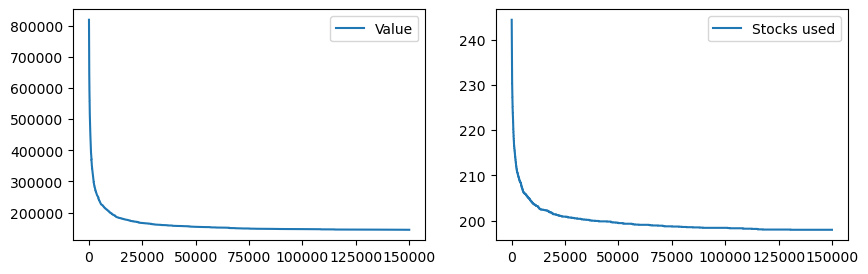

In [18]:
sa_test_avg_value(num_iters=150000)

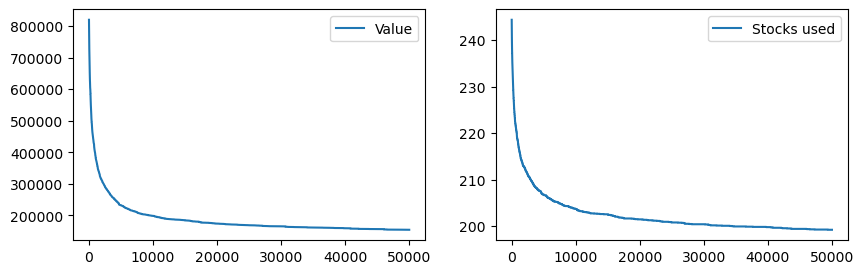

In [20]:
sa_test_avg_value(num_iters=50000)

Percentage improvement of value and num stocks through iterations

In [29]:
def sa_test_perc_improvement(num_iters):
    num_instances = 21
    sum_value_perc_improvement = [0 for _ in range(num_iters)]
    sum_num_stocks_perc_improvement = [0 for _ in range(num_iters)]
    
    for i in range(num_instances):
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        print(f'Instance {i+1}/{num_instances}  ', end='\r')
        _, value, num_stocks = simulated_annealing(orders,
                                                   max_iters=num_iters,
                                                   sum_value_perc_improvement=sum_value_perc_improvement,
                                                   sum_num_stocks_perc_improvement=sum_num_stocks_perc_improvement
                                                  )
    
    avg_value_perc_improvement = [x / num_instances for x in sum_value_perc_improvement]
    avg_num_stocks_perc_improvement = [x / num_instances for x in sum_num_stocks_perc_improvement]
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_iters), avg_value_perc_improvement, label='Value percenatage improvement')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(num_iters), avg_num_stocks_perc_improvement, label='Stocks used percentage improvement')
    plt.legend()
    plt.show()

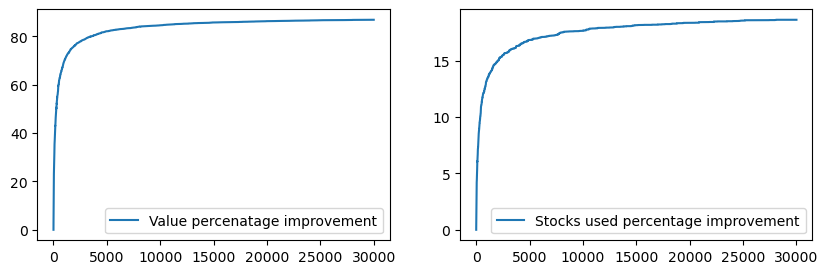

In [30]:
sa_test_perc_improvement(num_iters=30000)

# Genetic algorithm

In [13]:
POPULATION_SIZE = 50
NUM_ITERS = 200
ELITISM_SIZE = 6
MUTATION_PROB = 0.02
CROSSOVER_PROB = 0.9
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]
MC_OPTION = 'FIXED'

class Individual:
    def __init__(self, orders):
        code = deepcopy(orders)
        random.shuffle(code)
        self.code = code
        self.fitness, self.num_stocks = calc_solution_value(self.code)

In [29]:
def ga(orders:    list[int],
       selection: Callable[[list[Individual], Individual], Individual] = tournament_selection,
       crossover: Callable[[Individual, Individual, Individual, Individual], None] = generalized_order_crossover,
       mutation:  Callable[[Individual], None] = mutation_swap,
       plot: bool = False,
       POPULATION_SIZE: int = 100,
       MC_OPTION: str = 'FIXED',
       CROSSOVER_PROB: float = 0.85,
       MUTATION_PROB: float = 0.07,
       NUM_ITERS: int = 100,
       ELITISM_SIZE: int = 4,
       sum_best_solutions: list[int] = None,
       sum_num_stocks: list[int] = None
      ):
    
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = deepcopy(population)
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for it in range(NUM_ITERS):
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = deepcopy(population[:ELITISM_SIZE])
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)
        
        if MC_OPTION == 'DHM/ILC':
            MUTATION_PROB = 1 - (it / (NUM_ITERS - 1))
            MUTATION_PROB = mutation_lb + (mutation_ub - mutation_lb) * MUTATION_PROB

            CROSSOVER_PROB = it / (NUM_ITERS - 1)
            CROSSOVER_PROB = crossover_lb + (crossover_ub - crossover_lb) * CROSSOVER_PROB
            
        elif MC_OPTION == 'ILM/DHC':
            MUTATION_PROB = it / (NUM_ITERS - 1)
            MUTATION_PROB = mutation_lb + (mutation_ub - mutation_lb) * MUTATION_PROB
            
            CROSSOVER_PROB = 1 - (it / (NUM_ITERS - 1))
            CROSSOVER_PROB = crossover_lb + (crossover_ub - crossover_lb) * CROSSOVER_PROB
            
        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):            
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
                
            if random.random() < CROSSOVER_PROB:
                crossover(parent1, parent2, new_population[i], new_population[i+1])
            else:
                new_population[i] = deepcopy(parent1)
                new_population[i+1] = deepcopy(parent2)
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i])
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i+1]) 
                                       
            new_population[i].fitness, new_population[i].num_stocks = calc_solution_value(new_population[i].code)
            new_population[i+1].fitness, new_population[i+1].num_stocks = calc_solution_value(new_population[i+1].code)
        
        population = deepcopy(new_population)
    
    if plot:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
        
    if sum_best_solutions is not None:
        for i in range(len(sum_best_solutions)):
            sum_best_solutions[i] = sum_best_solutions[i] + PLT_VALUES[i]
        
    if sum_num_stocks is not None:
        for i in range(len(sum_num_stocks)):
            sum_num_stocks[i] = sum_num_stocks[i] + PLT_STOCKS_USED[i]
    
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

### Selection

In [15]:
import numpy as np

In [16]:
def tournament_selection(population, forbidden):
    allowed = list(set(population).difference({forbidden}))
    chosen = random.sample(allowed, TOURNAMENT_SIZE)
    return min(chosen, key=lambda x: x.fitness)

In [17]:
def roulette_selection(population, forbidden):    
    allowed = list(set(population).difference({forbidden}))
    allowed.sort(key=lambda x: x.fitness)
    fitness_sum = sum([a.fitness for a in allowed])
    
    probs = [a.fitness / fitness_sum for a in allowed]
    probs.reverse()
    
    return np.random.choice(allowed, p=probs)

In [18]:
def rank_selection(population, forbidden):    
    allowed = list(set(population).difference({forbidden}))
    allowed.sort(key=lambda x: x.fitness)
    n = len(allowed)
    probs = [0 for i in range(n)]
    
    for i, individual in enumerate(allowed):
        probs[i] = (1 / n) * ( (SELECTION_PRESSURE - (2 * SELECTION_PRESSURE - 2) * ( i / (n - 1))) )
                        
    return np.random.choice(allowed, p=probs)    

### Crossover

In [20]:
def partially_mapped_crossover(parent1, parent2, child1, child2):
    n = len(parent1.code)
    pos1 = random.randrange(1, int(round(n/2)))
    pos2 = pos1 + random.randrange(int(round(n/3)), int(round(n/2)))
    
    temp_array1 = [(0,0) for _ in range(len(parent1.code))]
    temp_array2 = [(0,0) for _ in range(len(parent1.code))]
    
    ind_array1 = []
    ind_array2 = []
    
    count_dict1 = {}
    count_dict2 = {}

    for num in parent1.code:
        count_dict1[num] = count_dict1.get(num, 0) + 1
        ind_array1.append(count_dict1[num])
              
    for num in parent2.code:
        count_dict2[num] = count_dict2.get(num, 0) + 1
        ind_array2.append(count_dict2[num])
      
    temp_array1[pos1:pos2] = [(parent2.code[i],ind_array2[i]) for i in range(pos1, pos2)]
    temp_array2[pos1:pos2] = [(parent1.code[i],ind_array1[i]) for i in range(pos1, pos2)]

    
    #todo
    ind = 0
    for i in range(len(parent1.code)):
        if i < pos1 or i >= pos2:
            while True:
                if (parent1.code[ind], ind_array1[ind]) not in temp_array1:
                    temp_array1[i] = (parent1.code[ind], ind_array1[ind])
                    ind += 1
                    break
                else:
                    ind += 1
      
    ind = 0
    for i in range(len(parent1.code)):
        if i < pos1 or i >= pos2:
            while True:
                if (parent2.code[ind], ind_array2[ind]) not in temp_array2:
                    temp_array2[i] = (parent2.code[ind], ind_array2[ind])
                    ind += 1
                    break
                else:
                    ind += 1
                    
    for i in range(len(parent1.code)):
        child1.code[i] = temp_array1[i][0]
        child2.code[i] = temp_array2[i][0]

In [21]:
def generalized_order_crossover(parent1, parent2, child1, child2):
    n = len(parent1.code)
    pos1 = random.randrange(1, int(round(n/2)))
    pos2 = pos1 + random.randrange(int(round(n/3)), int(round(n/2)))
    
    ind_array1 = []
    ind_array2 = []
    
    count_dict1 = {}
    count_dict2 = {}

    for num in parent1.code:
        count_dict1[num] = count_dict1.get(num, 0) + 1
        ind_array1.append(count_dict1[num])
              
    for num in parent2.code:
        count_dict2[num] = count_dict2.get(num, 0) + 1
        ind_array2.append(count_dict2[num])
      
    chosen1 = [(parent1.code[i], ind_array1[i]) for i in range(pos1, pos2)]
    chosen2 = [(parent2.code[i], ind_array2[i]) for i in range(pos1, pos2)]

    result1 = []
    result2 = []

    for i,num in enumerate(parent2.code):
        if (num, ind_array2[i]) == chosen1[0]:
            result1.extend([x[0] for x in chosen1])
            continue
        if (num, ind_array2[i]) in chosen1:
            continue
        result1.append(num)
        
    for i,num in enumerate(parent1.code):
        if (num, ind_array1[i]) == chosen2[0]:
            result2.extend([x[0] for x in chosen2])
            continue
        if (num, ind_array1[i]) in chosen2:
            continue
        result2.append(num)
       
    child1.code = result1
    child2.code = result2

In [22]:
from copy import deepcopy

In [23]:
def precedence_preservative_crossover(parent1, parent2, child1, child2):
    chosen_parent1 = random.choices([1, 2], k=len(parent1.code))
    chosen_parent2 = [2 if x == 1 else 1 for x in chosen_parent1]
    
    p1 = deepcopy(parent1.code)
    p2 = deepcopy(parent2.code)
    
    p12 = deepcopy(p1)
    p22 = deepcopy(p2)
    
    for i, num in enumerate(chosen_parent1):
        if num == 1:
            child1.code[i] = p1[0]
            p2.remove(p1[0])
            p1.pop(0)
            
        elif num == 2:
            child1.code[i] = p2[0]
            p1.remove(p2[0])
            p2.pop(0)
            
    for i, num in enumerate(chosen_parent2):
        if num == 1:
            child2.code[i] = p12[0]
            p22.remove(p12[0])
            p12.pop(0)
            
        elif num == 2:
            child2.code[i] = p22[0]
            p12.remove(p22[0])
            p22.pop(0)
    

### Mutation

In [24]:
def mutation_swap(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))

    tmp = instance.code[pos1]
    instance.code[pos1] = instance.code[pos2]
    instance.code[pos2] = tmp

In [25]:
def mutation_insert(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))
        
    element = instance.code.pop(pos1)
    instance.code.insert(pos2, element)

In [26]:
def mutation_inverse(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
        
    instance.code[pos1:pos2 + 1] = instance.code[pos1:pos2 + 1][::-1]

In [27]:
def mutation_shuffle(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
                
    segment = instance.code[pos1:pos2+1]
    random.shuffle(segment)
    
    instance.code[pos1:pos2+1] = segment

### Parameter tuning

In [30]:
import random
from time import perf_counter
import pandas as pd

In [31]:
def test_all_instances(combination_num,
                       results_df,
                       POPULATION_SIZE,
                       ELITISM_SIZE,
                       MC_OPTION,
                       MUTATION_PROB,
                       CROSSOVER_PROB,
                       NUM_ITERS,
                       selection_function,
                       crossover_function,
                       mutation_function
                      ):
    
    for i in range(21):        
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        
        solution, value, num_stocks = ga(orders,
                                         selection=selection_function,
                                         crossover=crossover_function,
                                         mutation=mutation_function,
                                         plot=False,
                                         POPULATION_SIZE = POPULATION_SIZE,
                                         MC_OPTION = MC_OPTION,
                                         CROSSOVER_PROB = CROSSOVER_PROB,
                                         MUTATION_PROB = MUTATION_PROB,
                                         NUM_ITERS = NUM_ITERS,
                                         ELITISM_SIZE = ELITISM_SIZE
                                        )
        
        results_df.loc[combination_num, ['selection', 'crossover', 'mutation']] = [selection_function.__name__, crossover_function.__name__, mutation_function.__name__]
        results_df.loc[combination_num, [f'instance {i} value', f'instance {i} num stocks']] = [value, num_stocks]

#### Random search

In [29]:
TOURNAMENT_SIZE = 6

param_columns = ['elitism size', 'mc option', 'mutation prob', 'crossover prob']
instance_columns = [f'instance {i} value, num stocks' for i in range(21)]
columns = param_columns + instance_columns

results_df = pd.DataFrame(columns=columns)

mutation_lb = 0.05
mutation_ub = 0.2
crossover_lb = 0.7
crossover_ub = 0.95

num_combinations = 150

for i in range(150):
    print(f'Combination {i+1}/{num_combinations}')
    
#     POPULATION_SIZE = random.choice([50, 100, 300, 600, 800])
#     NUM_ITERS = random.choice([100, 200, 300, 400, 500])

    POPULATION_SIZE = 100
    NUM_ITERS = 100
    ELITISM_SIZE = int(random.choice([0, 0.02, 0.04, 0.06, 0.08, 0.1]) * POPULATION_SIZE)
    CROSSOVER_PROB = None
    MUTATION_PROB = None

    MC_OPTION = random.choice(['FIXED', 'DHM/ILC', 'ILM/DHC']) 
     
    if MC_OPTION == 'FIXED':
        CROSSOVER_PROB = random.choice([0.7, 0.75, 0.8, 0.85, 0.9])
        MUTATION_PROB = random.choice([0.05, 0.08, 0.1, 0.12,  0.15, 0.2])
            
    test_all_instances(i,
                       results_df,
                       POPULATION_SIZE,
                       ELITISM_SIZE,
                       MC_OPTION,
                       MUTATION_PROB,
                       CROSSOVER_PROB,
                       NUM_ITERS
                      )

In [82]:
results_df

,elitism size,mc option,mutation prob,crossover prob,"instance 0 value, num stocks","instance 1 value, num stocks","instance 2 value, num stocks","instance 3 value, num stocks","instance 4 value, num stocks","instance 5 value, num stocks",...,"instance 11 value, num stocks","instance 12 value, num stocks","instance 13 value, num stocks","instance 14 value, num stocks","instance 15 value, num stocks","instance 16 value, num stocks","instance 17 value, num stocks","instance 18 value, num stocks","instance 19 value, num stocks","instance 20 value, num stocks"
0,0,ILM/DHC,None,None,"(620, 16)","(274, 19)","(7328, 49)","(5305, 51)","(1014, 33)","(103058, 127)",...,"(573937, 303)","(250943, 242)","(108933, 194)","(604481, 344)","(352721, 301)","(62126, 174)","(2478826, 605)","(1325641, 496)","(532945, 399)","(2758209, 694)"
1,0,DHM/ILC,None,None,"(720, 16)","(446, 19)","(6803, 49)","(4946, 50)","(1028, 33)","(103971, 127)",...,"(580553, 304)","(259815, 243)","(123140, 197)","(627547, 344)","(310741, 296)","(58636, 173)","(2465161, 607)","(1149246, 486)","(587142, 401)","(2894418, 703)"
2,6,DHM/ILC,None,None,"(1188, 17)","(487, 19)","(6929, 49)","(6914, 52)","(1059, 33)","(97889, 126)",...,"(572698, 303)","(238426, 240)","(104489, 195)","(543323, 339)","(363160, 301)","(59852, 174)","(2445065, 606)","(1297891, 492)","(623103, 403)","(2999531, 705)"
3,2,ILM/DHC,None,None,"(708, 16)","(365, 19)","(5942, 48)","(3575, 49)","(854, 33)","(97666, 126)",...,"(573835, 303)","(240111, 240)","(99665, 194)","(633168, 345)","(341014, 298)","(48196, 172)","(2404906, 604)","(1153731, 487)","(610520, 402)","(2758898, 697)"
4,6,DHM/ILC,None,None,"(1194, 17)","(326, 19)","(8025, 49)","(5172, 51)","(1187, 34)","(104663, 127)",...,"(591511, 304)","(220315, 238)","(96984, 193)","(606829, 345)","(390185, 305)","(54798, 171)","(2375681, 602)","(1426704, 499)","(576917, 400)","(2779017, 698)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,ILM/DHC,None,None,"(624, 16)","(670, 20)","(8523, 50)","(4636, 50)","(825, 33)","(104186, 127)",...,"(576095, 304)","(262574, 243)","(103545, 194)","(543811, 340)","(296879, 295)","(44994, 171)","(2442457, 605)","(1223126, 488)","(538928, 396)","(2729166, 694)"
146,6,ILM/DHC,None,None,"(1182, 17)","(724, 20)","(8567, 50)","(5251, 50)","(908, 33)","(103189, 127)",...,"(593241, 305)","(248708, 242)","(102928, 193)","(662028, 347)","(374781, 304)","(68516, 175)","(2464780, 606)","(1218374, 490)","(554277, 398)","(2740106, 693)"
147,0,ILM/DHC,None,None,"(651, 16)","(424, 19)","(5981, 48)","(4683, 50)","(852, 33)","(99259, 126)",...,"(578460, 303)","(233941, 241)","(96835, 193)","(589408, 342)","(333308, 301)","(54147, 172)","(2408292, 604)","(1239207, 489)","(533918, 398)","(2764563, 697)"
148,6,ILM/DHC,None,None,"(634, 16)","(325, 19)","(7393, 49)","(5725, 51)","(889, 33)","(98913, 126)",...,"(561595, 302)","(283479, 246)","(119287, 197)","(527835, 339)","(387111, 303)","(60882, 173)","(2392491, 602)","(1396921, 498)","(563828, 399)","(2941525, 701)"


In [83]:
results_df.to_csv('random_search.csv')

Chosen mutation/crossover probability option: fixed

#### Mutation probability tuning

In [27]:
MUTATION_PROBS = [0.03, 0.04, 0.05, 0.06, 0.07, 0.075, 0.08]
param_columns = ['mutation prob']
instance_columns = [f'instance {i} value, num stocks' for i in range(21)]
columns = param_columns + instance_columns

mutation_prob_df = pd.DataFrame(columns=columns)

combination_num = 0

for MUTATION_PROB in MUTATION_PROBS:
    for j in range(3):
        print(f'Combination {combination_num}/{len(MUTATION_PROBS*3)}      ', end='\r')
        test_all_instances(combination_num=combination_num,
                           results_df=mutation_prob_df,
                           POPULATION_SIZE=100,
                           ELITISM_SIZE=8,
                           MC_OPTION='FIXED',
                           MUTATION_PROB=MUTATION_PROB,
                           CROSSOVER_PROB=0.8,
                           NUM_ITERS=100)
        
        combination_num += 1

In [39]:
mutation_prob_df

,mutation prob,"instance 0 value, num stocks","instance 1 value, num stocks","instance 2 value, num stocks","instance 3 value, num stocks","instance 4 value, num stocks","instance 5 value, num stocks","instance 6 value, num stocks","instance 7 value, num stocks","instance 8 value, num stocks",...,"instance 11 value, num stocks","instance 12 value, num stocks","instance 13 value, num stocks","instance 14 value, num stocks","instance 15 value, num stocks","instance 16 value, num stocks","instance 17 value, num stocks","instance 18 value, num stocks","instance 19 value, num stocks","instance 20 value, num stocks"
0,0.03,"(1336, 17)","(843, 20)","(11649, 51)","(7484, 52)","(1638, 34)","(106677, 127)","(32829, 99)","(20798, 86)","(138837, 170)",...,"(588297, 304)","(271210, 243)","(147155, 200)","(739792, 354)","(405713, 305)","(70728, 176)","(2551415, 609)","(1487933, 502)","(731470, 412)","(3159523, 708)"
1,0.03,"(1195, 17)","(556, 20)","(13217, 52)","(8060, 52)","(2026, 35)","(109298, 128)","(29169, 98)","(18988, 87)","(152475, 173)",...,"(618589, 307)","(319805, 248)","(139918, 200)","(703502, 350)","(495315, 313)","(77111, 177)","(2616701, 611)","(1537439, 504)","(642925, 407)","(2777482, 699)"
2,0.03,"(1254, 17)","(727, 20)","(9433, 50)","(7228, 52)","(3129, 36)","(104178, 127)","(40605, 101)","(23902, 87)","(125830, 168)",...,"(613987, 307)","(293320, 246)","(143723, 201)","(739079, 353)","(468443, 310)","(81562, 178)","(2515378, 607)","(1425626, 497)","(755678, 414)","(3217429, 714)"
3,0.04,"(623, 16)","(322, 19)","(9808, 50)","(6678, 51)","(1324, 33)","(109546, 128)","(50524, 104)","(18609, 85)","(132309, 169)",...,"(603866, 305)","(319744, 249)","(142690, 200)","(676531, 348)","(425800, 309)","(74081, 178)","(2579363, 610)","(1307194, 494)","(653382, 408)","(2796355, 697)"
4,0.04,"(1172, 17)","(696, 20)","(11202, 51)","(7892, 52)","(1665, 34)","(108882, 128)","(34562, 99)","(28019, 89)","(134610, 169)",...,"(586501, 304)","(327480, 250)","(147611, 203)","(679118, 349)","(461520, 312)","(67935, 175)","(2576076, 610)","(1306801, 493)","(636601, 405)","(3131738, 710)"
5,0.04,"(645, 16)","(469, 19)","(9861, 50)","(7466, 52)","(1367, 34)","(105425, 127)","(38324, 101)","(19217, 86)","(146494, 171)",...,"(621042, 307)","(341936, 250)","(137233, 200)","(601760, 343)","(445246, 310)","(66599, 175)","(2543756, 608)","(1522861, 503)","(706861, 409)","(2778729, 699)"
6,0.05,"(1219, 17)","(838, 20)","(11398, 51)","(6463, 51)","(1618, 34)","(111380, 128)","(36071, 100)","(19594, 86)","(125369, 167)",...,"(596545, 305)","(284390, 246)","(127662, 199)","(692761, 349)","(478007, 313)","(65358, 174)","(2465416, 607)","(1503619, 503)","(681891, 410)","(2702182, 693)"
7,0.05,"(1213, 17)","(373, 19)","(9661, 50)","(4475, 50)","(1554, 34)","(103975, 127)","(40229, 102)","(20422, 86)","(129673, 168)",...,"(586399, 304)","(288145, 245)","(122112, 197)","(681628, 349)","(409016, 306)","(73930, 176)","(2663416, 613)","(1312741, 494)","(654851, 406)","(2974867, 704)"
8,0.05,"(658, 16)","(721, 20)","(9285, 50)","(7703, 52)","(1723, 34)","(103697, 127)","(34183, 100)","(19090, 86)","(134445, 169)",...,"(602097, 305)","(311546, 248)","(134612, 200)","(671563, 348)","(423672, 307)","(72675, 176)","(2495665, 607)","(1429013, 500)","(651225, 406)","(2893043, 702)"
9,0.06,"(658, 16)","(441, 19)","(8780, 50)","(5640, 51)","(1424, 34)","(106120, 127)","(29910, 98)","(17344, 85)","(136773, 170)",...,"(612439, 306)","(281295, 244)","(119331, 196)","(659280, 347)","(376372, 302)","(61156, 175)","(2496007, 606)","(1318838, 493)","(629048, 404)","(3034324, 705)"


In [40]:
mutation_prob_df.to_csv('mutation_probs.csv')

Chosen mutation probability: 0.07

In [2]:
import pandas as pd

In [1]:
import pandas as pd
from time import perf_counter

CROSSOVER_PROBS = [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
param_columns = ['crossover prob']
instance_columns = [f'instance {i} value, num stocks' for i in range(21)]
columns = param_columns + instance_columns

crossover_prob_df = pd.DataFrame(columns=columns)

comb_num = 0

for CROSSOVER_PROB in CROSSOVER_PROBS:
    for j in range(3):
        print(f'Combination {comb_num}/{len(CROSSOVER_PROBS)*3}    ', end='\r')
        test_all_instances(combination_num=comb_num,
                           results_df=crossover_prob_df,
                           POPULATION_SIZE=100,
                           ELITISM_SIZE=8,
                           MC_OPTION='FIXED',
                           MUTATION_PROB=0.065,
                           CROSSOVER_PROB=CROSSOVER_PROB,
                           NUM_ITERS=100)
        comb_num+=1

In [4]:
crossover_prob_df

,Unnamed: 0,crossover prob,"instance 0 value, num stocks","instance 1 value, num stocks","instance 2 value, num stocks","instance 3 value, num stocks","instance 4 value, num stocks","instance 5 value, num stocks","instance 6 value, num stocks","instance 7 value, num stocks",...,"instance 11 value, num stocks","instance 12 value, num stocks","instance 13 value, num stocks","instance 14 value, num stocks","instance 15 value, num stocks","instance 16 value, num stocks","instance 17 value, num stocks","instance 18 value, num stocks","instance 19 value, num stocks","instance 20 value, num stocks"
0,0,0.60,"(617, 16)","(449, 19)","(7192, 49)","(6694, 52)","(1504, 34)","(106382, 127)","(31768, 99)","(19584, 86)",...,"(592680, 305)","(289694, 246)","(122063, 197)","(638469, 345)","(425552, 308)","(63909, 173)","(2513691, 607)","(1450344, 499)","(657481, 407)","(2869850, 701)"
1,1,0.60,"(688, 16)","(350, 19)","(10275, 51)","(5925, 51)","(1723, 34)","(99015, 126)","(40451, 102)","(16106, 84)",...,"(584305, 304)","(285477, 245)","(129309, 198)","(655246, 347)","(408102, 305)","(66137, 174)","(2473204, 607)","(1464122, 501)","(635911, 403)","(2955573, 703)"
2,2,0.60,"(1254, 17)","(445, 19)","(11033, 51)","(5712, 51)","(1079, 33)","(104188, 127)","(31038, 98)","(15582, 84)",...,"(599519, 305)","(315246, 248)","(98129, 193)","(627380, 345)","(414904, 307)","(69371, 175)","(2498452, 608)","(1478580, 501)","(642866, 404)","(2894495, 700)"
3,3,0.70,"(667, 16)","(425, 19)","(9487, 50)","(7799, 52)","(1292, 34)","(103899, 127)","(37182, 100)","(14499, 83)",...,"(572260, 303)","(290015, 245)","(119580, 197)","(618823, 345)","(404618, 306)","(64795, 175)","(2520716, 607)","(1448692, 500)","(627533, 404)","(2861154, 701)"
4,4,0.70,"(623, 16)","(654, 20)","(11013, 51)","(6427, 51)","(1017, 33)","(100786, 126)","(32926, 99)","(15902, 85)",...,"(594588, 305)","(274207, 244)","(123702, 197)","(645696, 347)","(377072, 303)","(66030, 175)","(2467132, 606)","(1374412, 495)","(598242, 401)","(2926747, 704)"
5,5,0.70,"(1192, 17)","(369, 19)","(10734, 51)","(4837, 50)","(1414, 34)","(103659, 127)","(37213, 101)","(16769, 85)",...,"(598229, 305)","(309227, 247)","(123017, 198)","(654211, 347)","(402260, 306)","(69527, 176)","(2518274, 608)","(1465346, 500)","(661994, 407)","(2925130, 702)"
6,6,0.75,"(1193, 17)","(602, 20)","(7979, 49)","(4867, 50)","(1460, 34)","(103666, 127)","(29461, 98)","(18686, 86)",...,"(601523, 306)","(280044, 244)","(117387, 197)","(601983, 343)","(386059, 303)","(55556, 172)","(2553621, 609)","(1503502, 501)","(639067, 405)","(3125889, 709)"
7,7,0.75,"(618, 16)","(502, 19)","(9293, 50)","(5259, 50)","(1493, 34)","(103668, 127)","(29363, 98)","(18394, 85)",...,"(578605, 304)","(268794, 244)","(103950, 194)","(657567, 348)","(415103, 306)","(59949, 173)","(2469552, 606)","(1464259, 500)","(647197, 405)","(3017001, 706)"
8,8,0.75,"(624, 16)","(658, 20)","(8318, 50)","(6146, 51)","(1377, 34)","(99116, 126)","(38899, 101)","(17219, 85)",...,"(583808, 304)","(281517, 246)","(116124, 196)","(689591, 348)","(419754, 305)","(66584, 174)","(2506379, 608)","(1519431, 503)","(606120, 401)","(2896378, 703)"
9,9,0.80,"(642, 16)","(392, 19)","(9931, 50)","(6114, 51)","(1282, 34)","(104911, 127)","(37130, 100)","(15967, 85)",...,"(611163, 306)","(317955, 248)","(119112, 198)","(620011, 343)","(402258, 308)","(70283, 175)","(2377212, 602)","(1503370, 501)","(668632, 409)","(3029788, 708)"


In [5]:
crossover_prob_df.to_csv('crossover_probs.csv')

Chosen crossover probability: 0.85

#### Selection, crossover and mutation functions - grid search

In [28]:
selection_functions = [tournament_selection, roulette_selection, rank_selection]
crossover_functions = [precedence_preservative_crossover, generalized_order_crossover, partially_mapped_crossover]
mutation_functions = [mutation_swap, mutation_insert, mutation_inverse, mutation_shuffle]

param_columns = ['selection', 'crossover', 'mutation', 'time']
columns = param_columns + instance_columns

functions_df = pd.DataFrame(columns=columns)

TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5

combination_num = 0

for selection_function in selection_functions:
    for crossover_function in crossover_functions:
        for mutation_function in mutation_functions:
            print(f'Combination {combination_num+1}/9: ', end=' ')
            start = perf_counter()
            test_all_instances(combination_num=combination_num, 
                               results_df=functions_df, 
                               POPULATION_SIZE=100, 
                               ELITISM_SIZE=8, 
                               MC_OPTION='FIXED', 
                               MUTATION_PROB=0.07, 
                               CROSSOVER_PROB=0.85, 
                               NUM_ITERS=100,
                               selection_function=selection_function,
                               crossover_function=crossover_function,
                               mutation_function=mutation_function
                              )
            end = perf_counter()
            functions_df.loc[combination_num, 'time'] = end - start
            
            print(f'{end-start}s')
            combination_num += 1

In [51]:
functions_df

,selection,crossover,mutation,time,"instance 0 value, num stocks","instance 1 value, num stocks","instance 2 value, num stocks","instance 3 value, num stocks","instance 4 value, num stocks","instance 5 value, num stocks",...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,tournament_selection,precedence_preservative_crossover,mutation_shuffle,310.331088,NaN,NaN,NaN,NaN,NaN,NaN,...,82914.0,178.0,2516893.0,608.0,1490465.0,503.0,639136.0,404.0,3025181.0,705.0
1,tournament_selection,generalized_order_crossover,mutation_shuffle,615.760237,NaN,NaN,NaN,NaN,NaN,NaN,...,61074.0,173.0,2475225.0,605.0,1304773.0,493.0,666123.0,406.0,2629252.0,691.0
2,tournament_selection,partially_mapped_crossover,mutation_shuffle,1427.778796,NaN,NaN,NaN,NaN,NaN,NaN,...,86021.0,177.0,2521628.0,606.0,1514389.0,503.0,730704.0,410.0,3195439.0,710.0
3,roulette_selection,precedence_preservative_crossover,mutation_shuffle,469.593308,NaN,NaN,NaN,NaN,NaN,NaN,...,122575.0,184.0,2828488.0,618.0,2163381.0,527.0,1005714.0,429.0,3761736.0,728.0
4,roulette_selection,generalized_order_crossover,mutation_shuffle,540.993652,NaN,NaN,NaN,NaN,NaN,NaN,...,97736.0,179.0,2662432.0,611.0,1809262.0,513.0,935637.0,421.0,3379863.0,715.0
5,roulette_selection,partially_mapped_crossover,mutation_shuffle,584.38372,NaN,NaN,NaN,NaN,NaN,NaN,...,66702.0,173.0,2582372.0,606.0,1624903.0,507.0,726245.0,410.0,3374656.0,714.0
6,rank_selection,precedence_preservative_crossover,mutation_shuffle,201.698493,NaN,NaN,NaN,NaN,NaN,NaN,...,113147.0,182.0,2869070.0,619.0,1958226.0,521.0,958507.0,424.0,3854793.0,734.0
7,rank_selection,generalized_order_crossover,mutation_shuffle,375.445684,NaN,NaN,NaN,NaN,NaN,NaN,...,75678.0,176.0,2559449.0,606.0,1483265.0,502.0,818164.0,416.0,3214008.0,710.0
8,rank_selection,partially_mapped_crossover,mutation_shuffle,615.033576,NaN,NaN,NaN,NaN,NaN,NaN,...,69107.0,172.0,2423400.0,601.0,1528064.0,503.0,705121.0,409.0,2997020.0,702.0


In [29]:
functions_df.to_csv('functions.csv')

Chosen selection function: tournament selection \
Chosen mutation function: swap

In [29]:
crossover_functions = [generalized_order_crossover, partially_mapped_crossover]
crossover_fun_df = pd.DataFrame(columns=['crossover'])

combination_num = 0

for crossover_function in crossover_functions:
    for i in range(3):
        print(f'Combination {combination_num+1}/6 ', end='\r')
        test_all_instances(combination_num=combination_num, 
                           results_df=crossover_fun_df, 
                           POPULATION_SIZE=100, 
                           ELITISM_SIZE=8, 
                           MC_OPTION='FIXED',
                           MUTATION_PROB=0.07, 
                           CROSSOVER_PROB=0.85, 
                           NUM_ITERS=100,
                           selection_function=tournament_selection,
                           crossover_function=crossover_function,
                           mutation_function=mutation_swap
                          )
        combination_num += 1

In [31]:
crossover_fun_df.to_csv('crossover_functions.csv')

Chosen crossover function: generalized order crossover

In [2]:
ELITISM_SIZES = [0, 0.02, 0.04, 0.06, 0.08, 0.1]
param_columns = ['elitism size']

elitism_size_df = pd.DataFrame(columns=param_columns)

combination_num = 0

for ELITISM_SIZE in ELITISM_SIZES:
    for j in range(3):
        print(f'Combination {combination_num + 1}/{len(ELITISM_SIZES*3)}      ', end='\r')
        test_all_instances(combination_num=combination_num,
                           results_df=elitism_size_df,
                           selection_function=tournament_selection,
                           crossover_function=generalized_order_crossover,
                           mutation_function=mutation_swap,
                           POPULATION_SIZE=100,
                           ELITISM_SIZE=int(ELITISM_SIZE * 100),
                           MC_OPTION='FIXED',
                           MUTATION_PROB=0.07,
                           CROSSOVER_PROB=0.85,
                           NUM_ITERS=100)
        
        combination_num += 1

In [6]:
elitism_size_df

,Unnamed: 0,elitism size,instance 0 value,instance 0 num stocks,instance 1 value,instance 1 num stocks,instance 2 value,instance 2 num stocks,instance 3 value,instance 3 num stocks,...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,0,0,615.0,16.0,328.0,19.0,7097.0,49.0,4614.0,50.0,...,45163.0,170.0,2259343.0,597.0,974165.0,477.0,443455.0,389.0,2380341.0,683.0
1,1,0,1183.0,17.0,314.0,19.0,5623.0,48.0,3093.0,49.0,...,46829.0,171.0,2319535.0,600.0,1034110.0,480.0,472398.0,392.0,2383604.0,684.0
2,2,0,620.0,16.0,335.0,19.0,5499.0,48.0,3214.0,49.0,...,49476.0,172.0,2266714.0,598.0,987314.0,478.0,493579.0,395.0,2302299.0,679.0
3,3,2,620.0,16.0,277.0,19.0,5691.0,48.0,4418.0,50.0,...,35963.0,168.0,2319178.0,600.0,928797.0,473.0,468793.0,392.0,2516802.0,686.0
4,4,2,620.0,16.0,319.0,19.0,5763.0,48.0,3662.0,49.0,...,42577.0,169.0,2253325.0,597.0,962156.0,478.0,453749.0,391.0,2355760.0,682.0
5,5,2,615.0,16.0,328.0,19.0,5935.0,48.0,3070.0,49.0,...,48429.0,172.0,2262243.0,599.0,1000219.0,477.0,485075.0,394.0,2329612.0,683.0
6,6,4,627.0,16.0,284.0,19.0,6818.0,49.0,4215.0,50.0,...,38282.0,168.0,2251533.0,598.0,964545.0,477.0,459033.0,389.0,2337324.0,678.0
7,7,4,615.0,16.0,344.0,19.0,7255.0,49.0,3819.0,49.0,...,49605.0,172.0,2243885.0,598.0,1022215.0,479.0,451260.0,388.0,2364343.0,682.0
8,8,4,620.0,16.0,386.0,19.0,6035.0,48.0,2720.0,49.0,...,46604.0,170.0,2295980.0,600.0,842202.0,468.0,474892.0,392.0,2370230.0,682.0
9,9,6,1172.0,17.0,221.0,19.0,5829.0,48.0,5557.0,51.0,...,45567.0,170.0,2247137.0,598.0,1007944.0,478.0,491326.0,392.0,2317134.0,680.0


In [7]:
elitism_size_df.to_csv('elitism_size.csv')

Chosen elitism size: 4% of population size

In [8]:
TOURNAMENT_SIZES = [4, 5, 6]
tournament_size_df = pd.DataFrame(columns=['tournament size'])

combination_num = 0

for TOURNAMENT_SIZE in TOURNAMENT_SIZES:
    for j in range(3):
        print(f'Combination {combination_num + 1}/{len(TOURNAMENT_SIZES)*3}      ', end='\r')
        test_all_instances(combination_num=combination_num,
                           results_df=tournament_size_df,
                           selection_function=tournament_selection,
                           crossover_function=generalized_order_crossover,
                           mutation_function=mutation_swap,
                           POPULATION_SIZE=100,
                           ELITISM_SIZE=4,
                           MC_OPTION='FIXED',
                           MUTATION_PROB=0.07,
                           CROSSOVER_PROB=0.85,
                           NUM_ITERS=100, 
                           TOURNAMENT_SIZE=TOURNAMENT_SIZE) 
        combination_num += 1

In [10]:
tournament_size_df

,Unnamed: 0,tournament size,instance 0 value,instance 0 num stocks,instance 1 value,instance 1 num stocks,instance 2 value,instance 2 num stocks,instance 3 value,instance 3 num stocks,...,instance 16 value,instance 16 num stocks,instance 17 value,instance 17 num stocks,instance 18 value,instance 18 num stocks,instance 19 value,instance 19 num stocks,instance 20 value,instance 20 num stocks
0,0,4,617.0,16.0,354.0,19.0,5301.0,48.0,4812.0,51.0,...,50961.0,173.0,2312860.0,599.0,1054436.0,479.0,483724.0,393.0,2513252.0,687.0
1,1,4,648.0,16.0,226.0,19.0,6296.0,48.0,2458.0,48.0,...,42813.0,170.0,2344392.0,601.0,956811.0,475.0,474600.0,390.0,2410936.0,683.0
2,2,4,620.0,16.0,229.0,19.0,6022.0,48.0,4149.0,50.0,...,43546.0,170.0,2321783.0,600.0,1055536.0,479.0,484469.0,392.0,2520763.0,688.0
3,3,5,617.0,16.0,302.0,19.0,5581.0,48.0,3908.0,50.0,...,44414.0,170.0,2235423.0,597.0,953892.0,472.0,469324.0,390.0,2445043.0,684.0
4,4,5,615.0,16.0,283.0,19.0,5535.0,48.0,2349.0,48.0,...,47819.0,171.0,2253168.0,597.0,945076.0,474.0,532456.0,397.0,2503190.0,686.0
5,5,5,620.0,16.0,272.0,19.0,8986.0,50.0,4023.0,49.0,...,42825.0,169.0,2286960.0,599.0,981051.0,476.0,475821.0,392.0,2319382.0,680.0
6,6,6,620.0,16.0,289.0,19.0,6828.0,49.0,3254.0,49.0,...,47707.0,171.0,2288518.0,598.0,903951.0,471.0,478033.0,391.0,2432716.0,683.0
7,7,6,627.0,16.0,272.0,19.0,7214.0,49.0,3092.0,49.0,...,53490.0,172.0,2299701.0,599.0,977998.0,476.0,466929.0,392.0,2485712.0,689.0
8,8,6,625.0,16.0,375.0,19.0,6585.0,49.0,2638.0,49.0,...,43283.0,170.0,2277478.0,599.0,1010120.0,478.0,434580.0,389.0,2360635.0,681.0


In [11]:
tournament_size_df.to_csv('tournament_size.csv')

Chosen tournament size: 6

#### Number of iterations

In [40]:
def ga_test_num_iters(num_iters):
    num_instances = 21
    sum_best_values = [0 for _ in range(num_iters)]
    sum_num_stocks = [0 for _ in range(num_iters)] 

    for i in range(num_instances):
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        print(f'Instance: {i+1} / {num_instances}   ', end='\r')
        solution, value, num_stocks = ga(orders,
                                         selection=tournament_selection,
                                         crossover=generalized_order_crossover,
                                         mutation=mutation_swap,
                                         plot=False,
                                         POPULATION_SIZE = 100,
                                         MC_OPTION = 'FIXED',
                                         CROSSOVER_PROB = 0.85,
                                         MUTATION_PROB = 0.07,
                                         NUM_ITERS = num_iters,
                                         ELITISM_SIZE = 4,
                                         sum_best_solutions = sum_best_values,
                                         sum_num_stocks = sum_num_stocks
                                        )

    avg_best_values = [x / num_instances for x in sum_best_values]
    avg_num_stocks = [x / num_instances for x in sum_num_stocks]
    
    return avg_best_values, avg_num_stocks

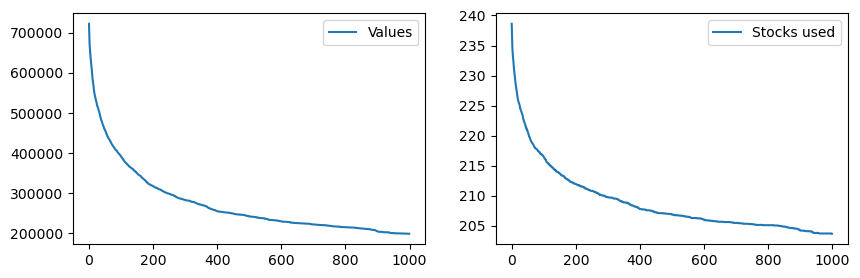

In [38]:
ga_avg_best_values, ga_avg_num_stocks = ga_test_num_iters(1000)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(range(num_iters), ga_avg_best_values, label='Values')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_iters), ga_avg_num_stocks, label='Stocks used')
plt.legend()
plt.show()        

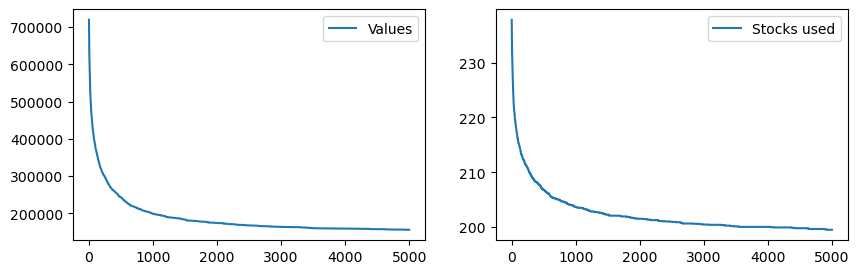

In [39]:
ga_avg_best_values, ga_avg_num_stocks = ga_test_num_iters(5000)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(range(num_iters), ga_avg_best_values, label='Values')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_iters), ga_avg_num_stocks, label='Stocks used')
plt.legend()
plt.show()        

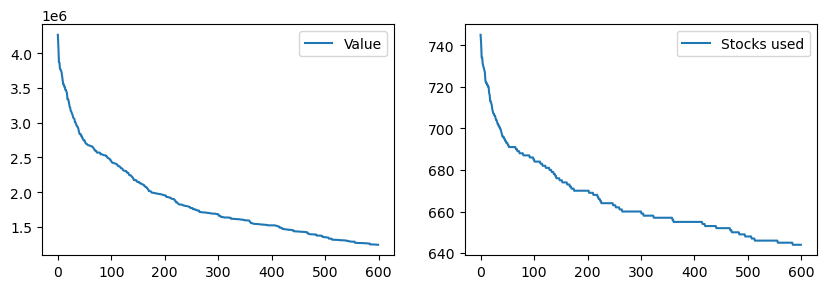

In [42]:
orders = read_instance('test_instances/test_instance_20.csp')
solution, value, num_stocks = ga(orders,
                                 selection=tournament_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_swap,
                                 plot=True,
                                 POPULATION_SIZE = 100,
                                 MC_OPTION = 'FIXED',
                                 CROSSOVER_PROB = 0.85,
                                 MUTATION_PROB = 0.07,
                                 NUM_ITERS = 600,
                                 ELITISM_SIZE = 4
                                )

In [43]:
print(value, num_stocks)

1242154 644


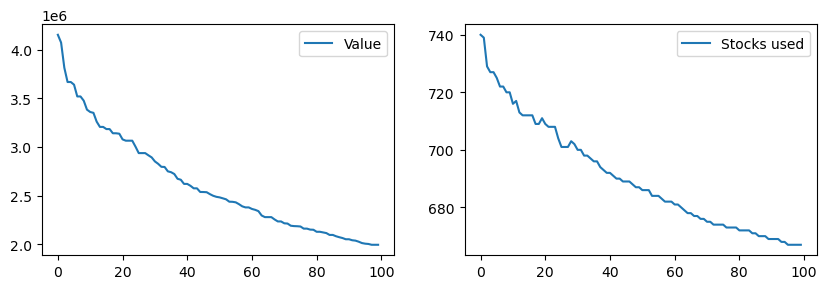

In [44]:
orders = read_instance('test_instances/test_instance_20.csp')
solution, value, num_stocks = ga(orders,
                                 selection=tournament_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_swap,
                                 plot=True,
                                 POPULATION_SIZE = 500,
                                 MC_OPTION = 'FIXED',
                                 CROSSOVER_PROB = 0.85,
                                 MUTATION_PROB = 0.07,
                                 NUM_ITERS = 100,
                                 ELITISM_SIZE = 20
                                )

In [45]:
print(value, num_stocks)

1994397 667


## SA, GA and CPLEX comparison

In [71]:
sa_ga_cplex_df = pd.DataFrame(columns=['algorithm'])

sa_ga_cplex_df.loc[0, 'algorithm'] = 'CPLEX'
sa_ga_cplex_df.loc[1, 'algorithm'] = 'SA'
sa_ga_cplex_df.loc[2, 'algorithm'] = 'GA'

cplex_df = pd.read_csv('tables/cplex/cplex.csv')

num_instances = 21

for i in range(num_instances):
    
    print(f'Instance {i+1}/{num_instances}  ', end='\r')
    
    if i <= 14:
        sa_ga_cplex_df.loc[0, f'instance {i} value'] = None
        sa_ga_cplex_df.loc[0, f'instance {i} num stocks'] = cplex_df.loc[0, f'instance {i} num stocks']
        sa_ga_cplex_df.loc[0, f'instance {i} time'] = cplex_df.loc[0, f'instance {i} time']
    
    orders = read_instance(f'test_instances/test_instance_{i}.csp')
    
    start = perf_counter()
    _, value, num_stocks = simulated_annealing(orders, max_iters=15000)
    end = perf_counter()
    
    sa_ga_cplex_df.loc[1, f'instance {i} value'] = value
    sa_ga_cplex_df.loc[1, f'instance {i} num stocks'] = num_stocks 
    sa_ga_cplex_df.loc[1, f'instance {i} time'] = end - start
    
    start = perf_counter()
    _, value, num_stocks = ga(orders,
                              selection=tournament_selection,
                              crossover=generalized_order_crossover,
                              mutation=mutation_swap,
                              plot=False,
                              POPULATION_SIZE = 100,
                              MC_OPTION = 'FIXED',
                              CROSSOVER_PROB = 0.85,
                              MUTATION_PROB = 0.07,
                              NUM_ITERS = 600,
                              ELITISM_SIZE = 4
                             )
    end = perf_counter()
    
    sa_ga_cplex_df.loc[2, f'instance {i} value'] = value
    sa_ga_cplex_df.loc[2, f'instance {i} num stocks'] = num_stocks 
    sa_ga_cplex_df.loc[2, f'instance {i} time'] = end - start

In [27]:
sa_ga_cplex_df

,algorithm,instance 0 value,instance 0 num stocks,instance 0 time,instance 1 value,instance 1 num stocks,instance 1 time,instance 2 value,instance 2 num stocks,instance 2 time,...,instance 17 time,instance 18 value,instance 18 num stocks,instance 18 time,instance 19 value,instance 19 num stocks,instance 19 time,instance 20 value,instance 20 num stocks,instance 20 time
0,CPLEX,NaN,17.0,0.425326,NaN,20.0,0.277497,NaN,49.0,16.013496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SA,615.0,16.0,0.188738,133.0,19.0,0.257044,4868.0,48.0,0.427686,...,5.550174,130476.0,424.0,4.427695,55817.0,356.0,4.672292,759382.0,626.0,6.099560
2,GA,615.0,16.0,2.026955,209.0,19.0,2.781440,5103.0,48.0,4.483058,...,106.668009,353915.0,441.0,130.656233,186326.0,370.0,159.464895,1218154.0,644.0,196.271606


In [42]:
value_df = sa_ga_cplex_df.filter(like='value').T
num_stocks_df = sa_ga_cplex_df.filter(like='num stocks').T
time_df = sa_ga_cplex_df.filter(like='time').T

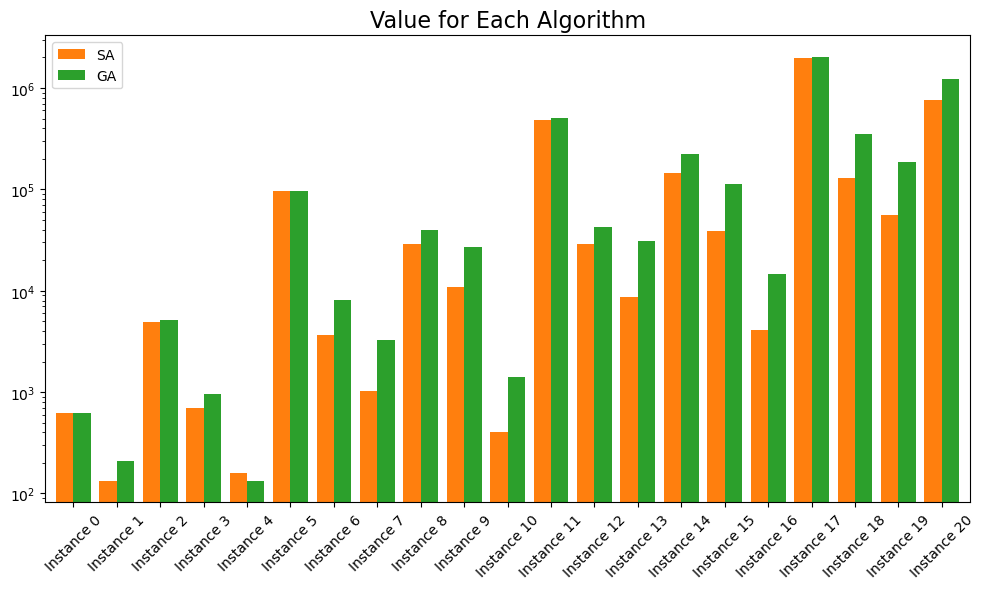

In [48]:
ax = value_df.plot(kind='bar', figsize=(10, 6), width=0.8, logy=True)
ax.set_title("Value for Each Algorithm", fontsize=16)
ax.set_xticklabels(["Instance " + str(i) for i in range(len(value_df))], rotation=45)
ax.legend(["SA", "GA"])

plt.tight_layout()

plt.show()

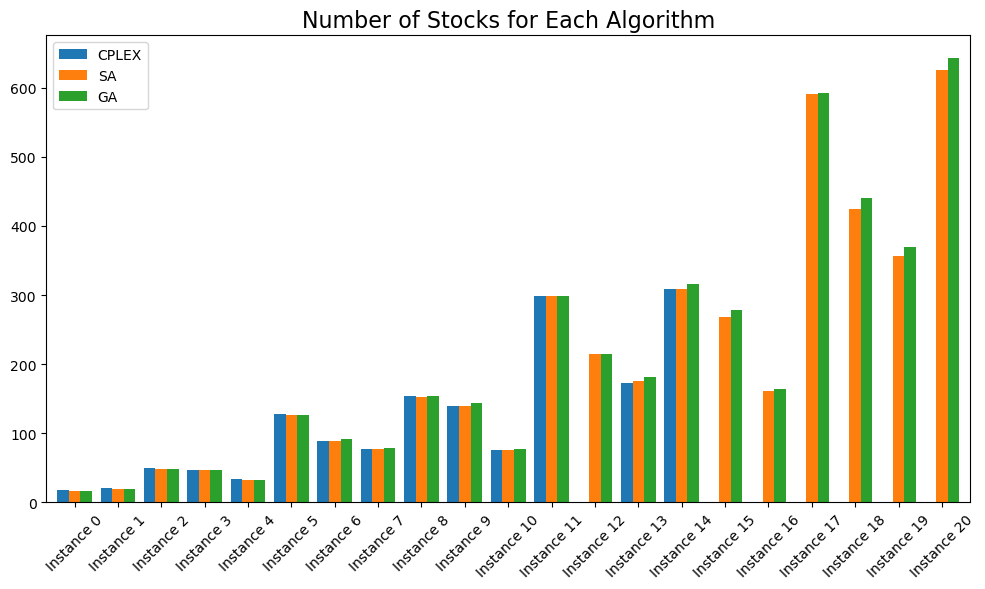

In [30]:
bx = num_stocks_df.plot(kind='bar', figsize=(10, 6), width=0.8)
bx.set_title("Number of Stocks for Each Algorithm", fontsize=16)
bx.set_xticklabels(["Instance " + str(i) for i in range(len(num_stocks_df))], rotation=45)
bx.legend(["CPLEX","SA", "GA"])

plt.tight_layout()

plt.show()

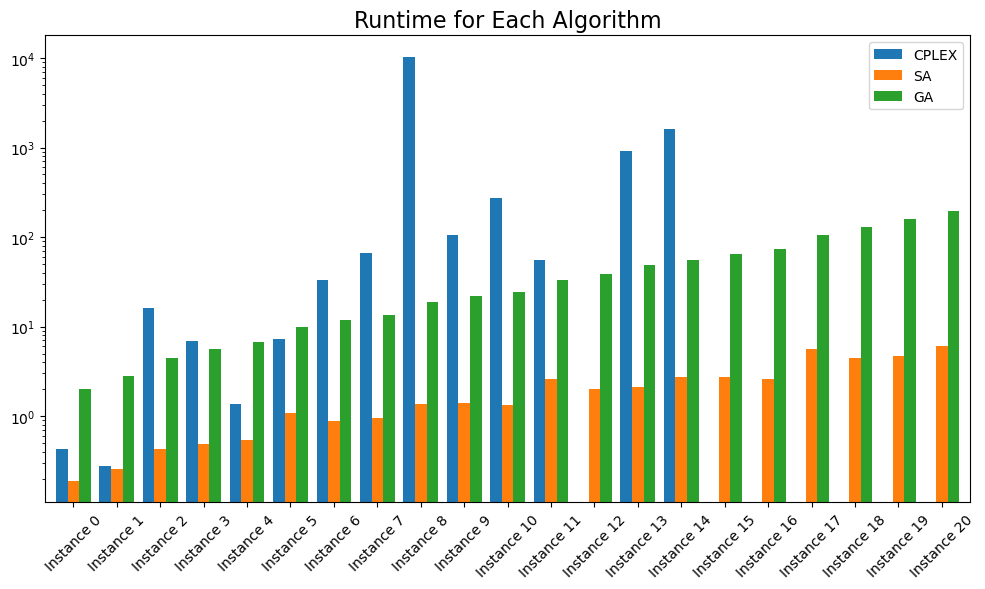

In [31]:
cx = time_df.plot(kind='bar', figsize=(10, 6), width=0.8, logy=True)
cx.set_title("Runtime for Each Algorithm", fontsize=16)
cx.set_xticklabels(["Instance " + str(i) for i in range(len(time_df))], rotation=45)
cx.legend(["CPLEX","SA", "GA"])

plt.tight_layout()

plt.show()

In [78]:
lowest_value_count_df = pd.DataFrame(columns=['CPLEX', 'SA', 'GA'])
lowest_num_stocks_count_df = pd.DataFrame(columns=['CPLEX', 'SA', 'GA'])
lowest_time_count_df = pd.DataFrame(columns=['CPLEX', 'SA', 'GA'])

lowest_value_count_df.loc['Number of lowest values'] = [
    (sa_ga_cplex_df.iloc[0, sa_ga_cplex_df.columns.str.contains('value')] == sa_ga_cplex_df.filter(like='value').min()).sum(),
    (sa_ga_cplex_df.iloc[1, sa_ga_cplex_df.columns.str.contains('value')] == sa_ga_cplex_df.filter(like='value').min()).sum(),
    (sa_ga_cplex_df.iloc[2, sa_ga_cplex_df.columns.str.contains('value')] == sa_ga_cplex_df.filter(like='value').min()).sum()
]

lowest_num_stocks_count_df.loc['Number of lowest num stocks'] = [
    (sa_ga_cplex_df.iloc[0, sa_ga_cplex_df.columns.str.contains('num stocks')] == sa_ga_cplex_df.filter(like='num stocks').min()).sum(),
    (sa_ga_cplex_df.iloc[1, sa_ga_cplex_df.columns.str.contains('num stocks')] == sa_ga_cplex_df.filter(like='num stocks').min()).sum(),
    (sa_ga_cplex_df.iloc[2, sa_ga_cplex_df.columns.str.contains('num stocks')] == sa_ga_cplex_df.filter(like='num stocks').min()).sum()
]

lowest_time_count_df.loc['Number of lowest runtimes'] = [
    (sa_ga_cplex_df.iloc[0, sa_ga_cplex_df.columns.str.contains('time')] == sa_ga_cplex_df.filter(like='time').min()).sum(),
    (sa_ga_cplex_df.iloc[1, sa_ga_cplex_df.columns.str.contains('time')] == sa_ga_cplex_df.filter(like='time').min()).sum(),
    (sa_ga_cplex_df.iloc[2, sa_ga_cplex_df.columns.str.contains('time')] == sa_ga_cplex_df.filter(like='time').min()).sum()
]

lowest_count_df = pd.concat([lowest_value_count_df, lowest_num_stocks_count_df, lowest_time_count_df])

In [79]:
lowest_count_df

,CPLEX,SA,GA
Number of lowest values,0,20,2
Number of lowest num stocks,7,18,7
Number of lowest runtimes,0,21,0


## Genetic algorithm + Simulated annealing

#### GA + SA on every individual in every generation

In [39]:
def ga_plus_sa(orders:    list[int],
               selection: Callable[[list[Individual], Individual], Individual] = tournament_selection,
               crossover: Callable[[Individual, Individual, Individual, Individual], None] = generalized_order_crossover,
               mutation:  Callable[[Individual], None] = mutation_swap,
               plot: bool = False,
               POPULATION_SIZE: int = 100,
               CROSSOVER_PROB: float = 0.85,
               MUTATION_PROB: float = 0.07,
               NUM_ITERS: int = 100,
               ELITISM_SIZE: int = 4,
               ):
    
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = deepcopy(population)
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for it in range(NUM_ITERS):
        print(f'Generation {it+1}/{NUM_ITERS}  ', end='\r')
        
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = deepcopy(population[:ELITISM_SIZE])
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)
        
            
        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):            
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
                
            if random.random() < CROSSOVER_PROB:
                crossover(parent1, parent2, new_population[i], new_population[i+1])
            else:
                new_population[i] = deepcopy(parent1)
                new_population[i+1] = deepcopy(parent2)
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i])
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i+1])
                
            solution, value, num_stocks = simulated_annealing(new_population[i].code,
                                                              max_iters = 1000
                                                             )
            new_population[i].code[:] = solution[:]
            new_population[i].fitness = value
            new_population[i].num_stocks = num_stocks
            
            solution, value, num_stocks = simulated_annealing(new_population[i+1].code,
                                                              max_iters = 1000
                                                             )
            new_population[i+1].code[:] = solution[:]
            new_population[i+1].fitness = value
            new_population[i+1].num_stocks = num_stocks

        population = deepcopy(new_population)
    
    if plot:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
        
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

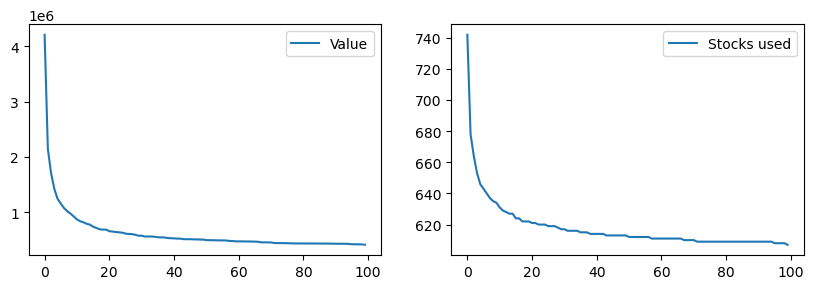

412653 607


In [40]:
orders = read_instance('test_instances/test_instance_20.csp')
_, value, num_stocks = ga_plus_sa(orders, plot=True)
print(value, num_stocks)

#### GA + SA on the best individual in every generation

In [34]:
def ga_plus_sa_2(orders:    list[int],
                 selection: Callable[[list[Individual], Individual], Individual] = tournament_selection,
                 crossover: Callable[[Individual, Individual, Individual, Individual], None] = generalized_order_crossover,
                 mutation:  Callable[[Individual], None] = mutation_swap,
                 plot: bool = False,
                 POPULATION_SIZE: int = 100,
                 CROSSOVER_PROB: float = 0.85,
                 MUTATION_PROB: float = 0.07,
                 NUM_ITERS: int = 100,
                 ELITISM_SIZE: int = 4,
                 ):
    
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = deepcopy(population)
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for it in range(NUM_ITERS):
        print(f'Generation {it+1}/{NUM_ITERS}  ', end='\r')
        
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = deepcopy(population[:ELITISM_SIZE])
        
        solution, value, num_stocks = simulated_annealing(new_population[0].code,
                                                          max_iters = 1000
                                                          )
        new_population[0].code[:] = solution[:]
        new_population[0].fitness = value
        new_population[0].num_stocks = num_stocks
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)
            
        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):            
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
                
            if random.random() < CROSSOVER_PROB:
                crossover(parent1, parent2, new_population[i], new_population[i+1])
            else:
                new_population[i] = deepcopy(parent1)
                new_population[i+1] = deepcopy(parent2)
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i])
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i+1])    
                
            new_population[i].fitness, new_population[i].num_stocks = calc_solution_value(new_population[i].code)
            new_population[i+1].fitness, new_population[i+1].num_stocks = calc_solution_value(new_population[i+1].code)

        population = deepcopy(new_population)
    
    if plot:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
        
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

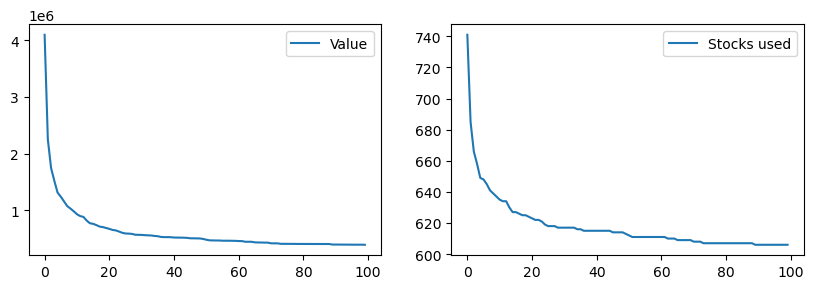

392029 606


In [42]:
orders = read_instance('test_instances/test_instance_20.csp')
_, value, num_stocks = ga_plus_sa_2(orders, plot=True)
print(value, num_stocks)

#### GA + SA on the best GA solution

In [51]:
def ga_plus_sa_3(orders):
    solution, value, num_stocks = ga(orders, plot=True)
    solution, value, num_stocks = simulated_annealing(solution, plot=True, max_iters=10000)
    print(value, num_stocks)

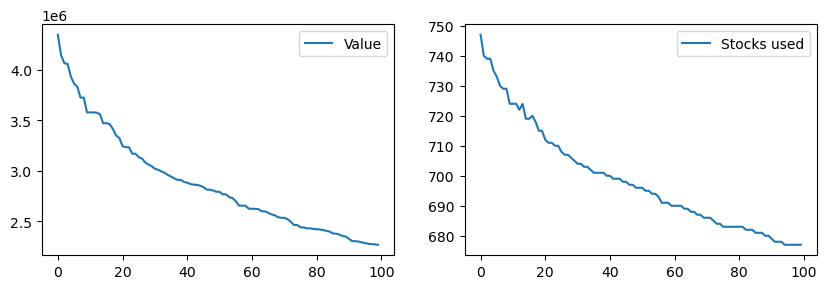

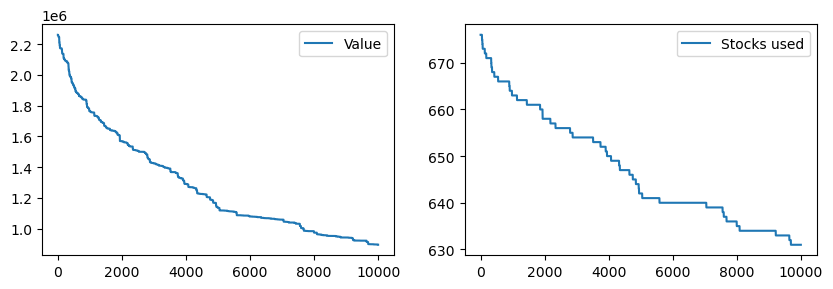

894335 631


In [52]:
orders = read_instance('test_instances/test_instance_20.csp')
ga_plus_sa_3(orders)

### Comparison

In [35]:
num_instances = 21
sa_ga_cplex_df.loc[3, 'algorithm'] = 'GA+SA'

for i in range(num_instances):
    
    print(f'Instance {i+1}/{num_instances}  ', end='\r')
    
    orders = read_instance(f'test_instances/test_instance_{i}.csp')
    
    start = perf_counter()
    _, value, num_stocks = ga_plus_sa_2(orders)
    end = perf_counter()
    
    sa_ga_cplex_df.loc[3, f'instance {i} value'] = value
    sa_ga_cplex_df.loc[3, f'instance {i} num stocks'] = num_stocks 
    sa_ga_cplex_df.loc[3, f'instance {i} time'] = end - start

In [36]:
sa_ga_cplex_df

,algorithm,instance 0 value,instance 0 num stocks,instance 0 time,instance 1 value,instance 1 num stocks,instance 1 time,instance 2 value,instance 2 num stocks,instance 2 time,...,instance 17 time,instance 18 value,instance 18 num stocks,instance 18 time,instance 19 value,instance 19 num stocks,instance 19 time,instance 20 value,instance 20 num stocks,instance 20 time
0,CPLEX,NaN,17.0,0.425326,NaN,20.0,0.277497,NaN,49.0,16.013496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SA,615.0,16.0,0.188738,133.0,19.0,0.257044,4868.0,48.0,0.427686,...,5.550174,130476.0,424.0,4.427695,55817.0,356.0,4.672292,759382.0,626.0,6.099560
2,GA,615.0,16.0,2.026955,209.0,19.0,2.781440,5103.0,48.0,4.483058,...,106.668009,353915.0,441.0,130.656233,186326.0,370.0,159.464895,1218154.0,644.0,196.271606
3,GA+SA,615.0,16.0,1.639726,132.0,19.0,2.271719,4854.0,48.0,3.760205,...,48.966861,31673.0,409.0,48.117019,13515.0,348.0,53.809687,458129.0,611.0,70.084794


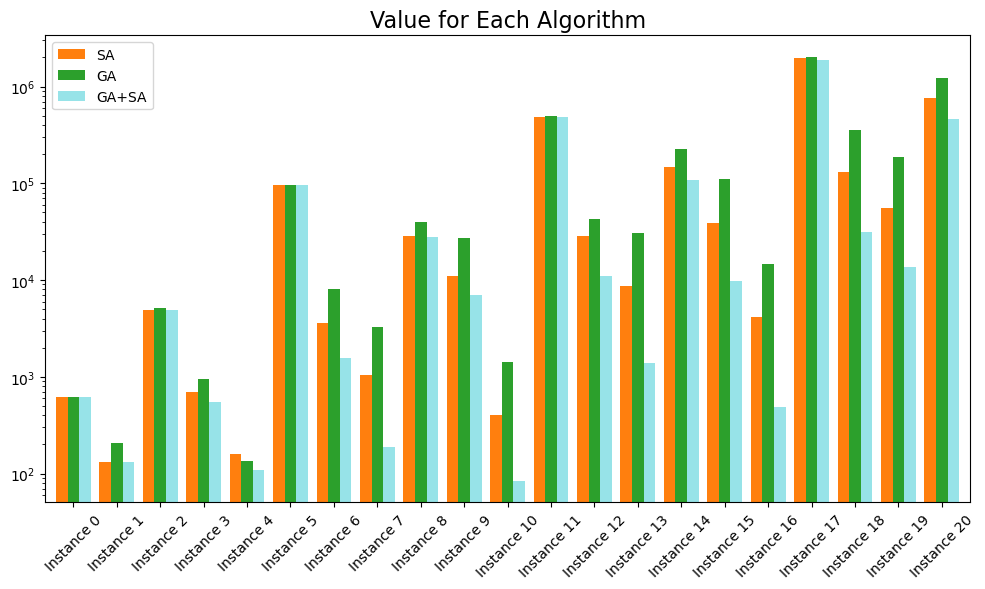

In [55]:
value_df = sa_ga_cplex_df.filter(like='value').T
num_stocks_df = sa_ga_cplex_df.filter(like='num stocks').T
time_df = sa_ga_cplex_df.filter(like='time').T

ax = value_df.plot(kind='bar', figsize=(10, 6), width=0.8, logy=True)
ax.set_title("Value for Each Algorithm", fontsize=16)
ax.set_xticklabels(["Instance " + str(i) for i in range(len(value_df))], rotation=45)
ax.legend(["SA", "GA", "GA+SA"])

plt.tight_layout()

plt.show()

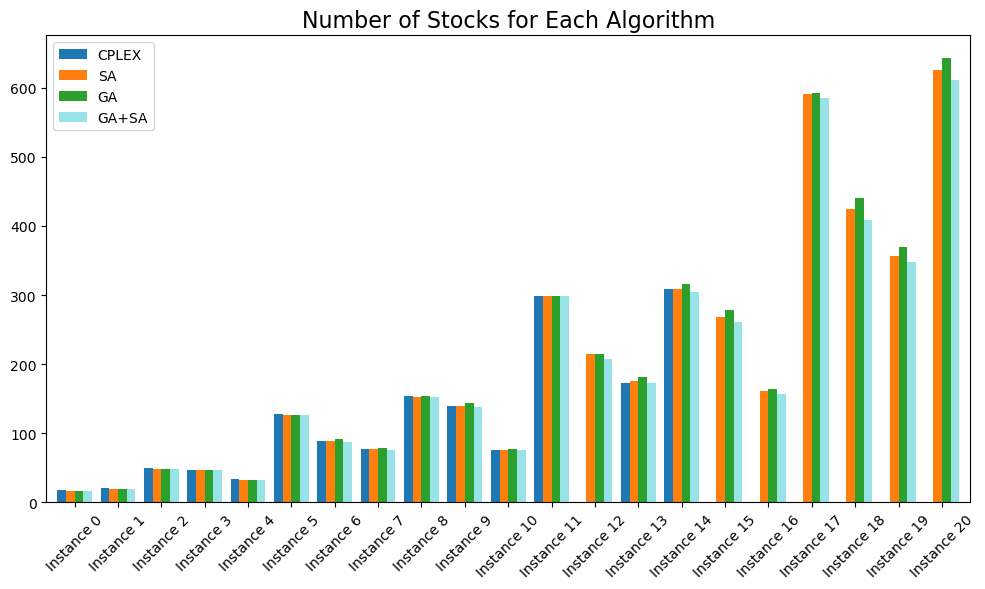

In [60]:
bx = num_stocks_df.plot(kind='bar', figsize=(10, 6), width=0.8)
bx.set_title("Number of Stocks for Each Algorithm", fontsize=16)
bx.set_xticklabels(["Instance " + str(i) for i in range(len(num_stocks_df))], rotation=45)
bx.legend(["CPLEX","SA", "GA", "GA+SA"])

plt.tight_layout()

plt.show()

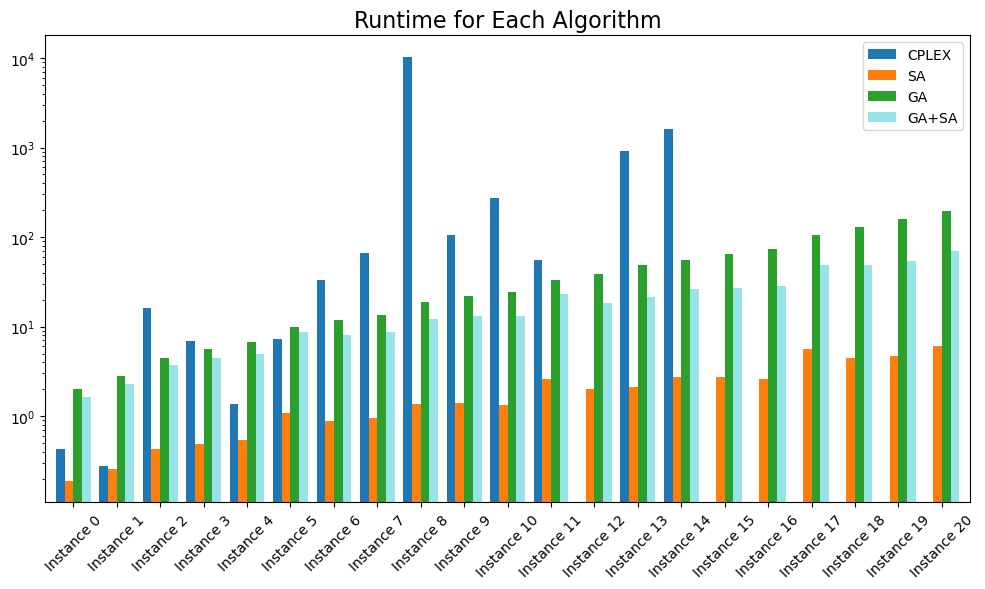

In [68]:
cx = time_df.plot(kind='bar', figsize=(10, 6), width=0.8, logy=True)
cx.set_title("Runtime for Each Algorithm", fontsize=16)
cx.set_xticklabels(["Instance " + str(i) for i in range(len(time_df))], rotation=45)
cx.legend(["CPLEX","SA", "GA", "GA+SA"])

plt.tight_layout()

plt.show()

In [69]:
lowest_value_count_df = pd.DataFrame(columns=['CPLEX', 'SA', 'GA', 'GA+SA'])
lowest_num_stocks_count_df = pd.DataFrame(columns=['CPLEX', 'SA', 'GA', 'GA+SA'])
lowest_time_count_df = pd.DataFrame(columns=['CPLEX', 'SA', 'GA', 'GA+SA'])

lowest_value_count_df.loc['Number of lowest values'] = [
    (sa_ga_cplex_df.iloc[0, sa_ga_cplex_df.columns.str.contains('value')] == sa_ga_cplex_df.filter(like='value').min()).sum(),
    (sa_ga_cplex_df.iloc[1, sa_ga_cplex_df.columns.str.contains('value')] == sa_ga_cplex_df.filter(like='value').min()).sum(),
    (sa_ga_cplex_df.iloc[2, sa_ga_cplex_df.columns.str.contains('value')] == sa_ga_cplex_df.filter(like='value').min()).sum(),
    (sa_ga_cplex_df.iloc[3, sa_ga_cplex_df.columns.str.contains('value')] == sa_ga_cplex_df.filter(like='value').min()).sum()

]

lowest_num_stocks_count_df.loc['Number of lowest num stocks'] = [
    (sa_ga_cplex_df.iloc[0, sa_ga_cplex_df.columns.str.contains('num stocks')] == sa_ga_cplex_df.filter(like='num stocks').min()).sum(),
    (sa_ga_cplex_df.iloc[1, sa_ga_cplex_df.columns.str.contains('num stocks')] == sa_ga_cplex_df.filter(like='num stocks').min()).sum(),
    (sa_ga_cplex_df.iloc[2, sa_ga_cplex_df.columns.str.contains('num stocks')] == sa_ga_cplex_df.filter(like='num stocks').min()).sum(),
    (sa_ga_cplex_df.iloc[3, sa_ga_cplex_df.columns.str.contains('num stocks')] == sa_ga_cplex_df.filter(like='num stocks').min()).sum()
]

lowest_time_count_df.loc['Number of lowest runtimes'] = [
    (sa_ga_cplex_df.iloc[0, sa_ga_cplex_df.columns.str.contains('time')] == sa_ga_cplex_df.filter(like='time').min()).sum(),
    (sa_ga_cplex_df.iloc[1, sa_ga_cplex_df.columns.str.contains('time')] == sa_ga_cplex_df.filter(like='time').min()).sum(),
    (sa_ga_cplex_df.iloc[2, sa_ga_cplex_df.columns.str.contains('time')] == sa_ga_cplex_df.filter(like='time').min()).sum(),
    (sa_ga_cplex_df.iloc[3, sa_ga_cplex_df.columns.str.contains('time')] == sa_ga_cplex_df.filter(like='time').min()).sum()
]

lowest_count_df = pd.concat([lowest_value_count_df, lowest_num_stocks_count_df, lowest_time_count_df])

In [70]:
lowest_count_df

,CPLEX,SA,GA,GA+SA
Number of lowest values,0,2,1,21
Number of lowest num stocks,2,8,6,21
Number of lowest runtimes,0,21,0,0
